# LUGEDA
Hetkel tegin ära metaandmete analüüsi, et oleks pilt silme ees mis andmetega üldse tegeleme.

Kõrvaldasin andmed, mis ei anna meile midagi juurde (heliklipi autor, litsents jne), et vähendada andmete mahtu.

Labelid, mida ennustada on metadata["primary_label"]. Lisaks sellele oleks mõistlik kasutada veerge latitude ja longitude, sest samadel linnuliikidel võib olla sõltuvalt asukohast dialekt. Samuti võiks type veerg väljundid olla kasulikud? Samas tasuks eelkõige keskenduda, kuidas teha mudel mis heli baasil üldse midagi ennustada oskab. Hiljem jõuab mõelda, kas ja kuidas lisada muid parameetreid.s

Panin kirja n-ö jägnevad tegevused, mida myb võiks teha? Esialgu tuleks mõelda, missugust eeltöötlus teha heliklippidele. Hetkel olen aru saanud, et heliklipid tuleks viia pildi kujule (nt. spectrogram). Võibolla oleks kasulik viia ka läbi mingisugune normaliseerimine? Tuleb ka mõelda, mida teha heliklippide pikkusega, sest heliklipid on väga erinevate pikkustega. Peale seda tuleks luua mudel, mis pildi klipist võtab ja treenib end vastavalt lindude labelitele.

TREENINGANDMED ON MAHUKAD. Enne vb võtta ainult kolm liiki ja neist igaühest 5-10 klippi?? Hoiab kokku aega mudeli katsetamisel ja allalaadimisel.


# Tehisintellekti 7. kodutöö
## BirdCLEF 2024
### Autorid: Charleen Konsa, Timo Kaasik ja Edvard Notberg

Seitsmenda kodutöö raames on plaanis lahendada Kaggle'i võistlust BirdCLEF 2024. Võistluse info asub lingil https://www.kaggle.com/competitions/birdclef-2024. Kasutatavad andmed on olemas võistluse lehel.

Töö eesmärk on kasutada masinõpet, et tuvastada heliklipi abil India linnuliike. Etteantud klipi puhul tuleb iga linnuliigi olemasolemise tõenäosus.

In [1]:
# Impordid
import pandas as pd
import ast
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [2]:
path = "/content/"

### Andmete uurimine ja puhastamine
Esmalt laeme alla faili train_metadata.csv. Selles hoiustatakse informatsiooni kõigi treeninghelikilppide kohta. Uurime ja analüüsime täpsemalt etteantud klippide informatsiooni, et paremini mõista, milliste andmetega tegutseme.

In [3]:
metadata = pd.read_csv(path + "train_metadata.csv")
print(f"Informatsiooni andmestiku suurus on {metadata.shape}. Seega on meil esialgu {metadata.shape[0]} heliklippi.")
print(f"Andmestikus on olemas read {list(metadata.columns)}.")
metadata.info()

Informatsiooni andmestiku suurus on (24459, 12). Seega on meil esialgu 24459 heliklippi.
Andmestikus on olemas read ['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'rating', 'url', 'filename'].
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  fil

Heliklippide informatsioon on jaotatud 12-sse tulpa. Kõigi tulpade informatsiooni pole aga tarvis seega on mõislik andmestikku eelnevalt korrastada. Lisaks on mõnes tulbas (latitude ja longitude) osa informatsioonist puudu, mis tuleb enne treenimist täita.

Eemaldatavate tulpade hulgas on järgnevad:


*   secondary_label
*   scientific_name
*   common_name
*   author
*   license
*   url

Treenimisel hakatakse ennustama tulpa primary_label, kus on linnu kohta käiv märgend. Kuna linde olev märgend on olemas, siis pole masinõppe jaoks tarvis teada linnu teaduslikku ega inimkeelset nime. Samuti on muu informatsioon autori, litsentsi kui ka heliklipi URLi kohta ebavajalik.

Reitingut on võimalik kasutada, et kaasata treenimisele ainult heliklippe, mille kvaliteet on parem ehk mudelil on lihtsam aru saada ja õppida lindude hääli.

In [4]:
# Ebavajalike veergude eemldamine
metadata = metadata.drop(["secondary_labels", "scientific_name", "common_name", "author", "license", "url"], axis = 1)
# Parema reitinguga heliklippide valimine
threshold = 3.0
metadata = metadata[metadata["rating"] >= threshold]
print(f"Informatsiooni andmestiku suurus on nüüd {metadata.shape}.")
# Enam pole rating veeru vaja ehk eemaldame ka selle
metadata = metadata.drop(["rating"], axis = 1)

Informatsiooni andmestiku suurus on nüüd (21506, 6).


In [5]:
# Latitude ja longitude Nan väärtuste väärtustamine
# Asendusväärtusteks võetakse keskmised väärtused
metadata["latitude"].fillna(metadata["latitude"].mean(), inplace=True)
metadata["longitude"].fillna(metadata["longitude"].mean(), inplace=True)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21506 entries, 0 to 24458
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   primary_label  21506 non-null  object 
 1   type           21506 non-null  object 
 2   latitude       21506 non-null  float64
 3   longitude      21506 non-null  float64
 4   filename       21506 non-null  object 
dtypes: float64(2), object(3)
memory usage: 1008.1+ KB


In [6]:
# Veeru type listiks muutmine
metadata["type"] = metadata["type"].apply(ast.literal_eval)
# Leiame, mis on 10 enimlevinud type väärtused ja viima iga väärtuse veeru kujule
type_count = Counter([item.lower() for sublist in metadata["type"] for item in sublist])
types = list(dict(sorted(type_count.items(), key=lambda item: item[1], reverse=True)).keys())
# Eemaldame tühja tüübi ja valime 10 kõige sagedasemat tüüpi
types.remove("")
frequent_types = types[:10]
# Iga tüübi jaoks luuakse veerg. Veerus on 1 kui see tüüp oli esialgses listis, muul juhul on 0
for frequent_type in frequent_types:
    metadata[frequent_type] = metadata["type"].apply(lambda x: 1 if frequent_type in [item.lower() for item in x] else 0)
# Eemaldame esialge type veeru
metadata = metadata.drop(["type"], axis = 1)

Edasi analüüsin alles jäänud heliklippide informatsiooni, et näha kas andmed on tasakaalus ja millised andmetega on täpselt tegu. Kuna allesjäänud veerge on vähe, siis pole keeruline neisse süüvida.

Erinevaid linnuliike on kokku 182.


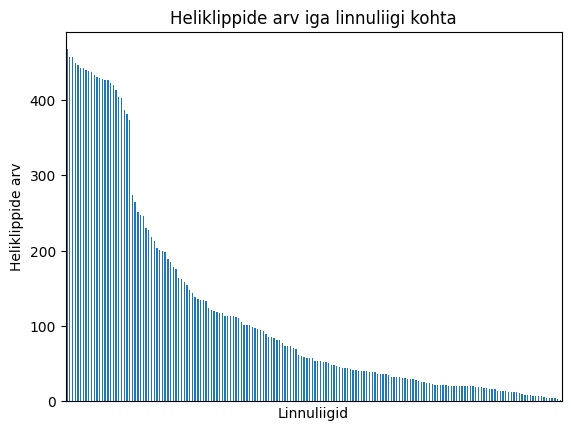

In [7]:
# Treeningandmete tasakaalukus linnuliikide alusel
bird_types = metadata["primary_label"].value_counts()
print(f"Erinevaid linnuliike on kokku {len(bird_types)}.")

bird_types.plot(kind="bar")
plt.title("Heliklippide arv iga linnuliigi kohta")
plt.xlabel("Linnuliigid")
plt.ylabel("Heliklippide arv")
plt.xticks([])
plt.show()

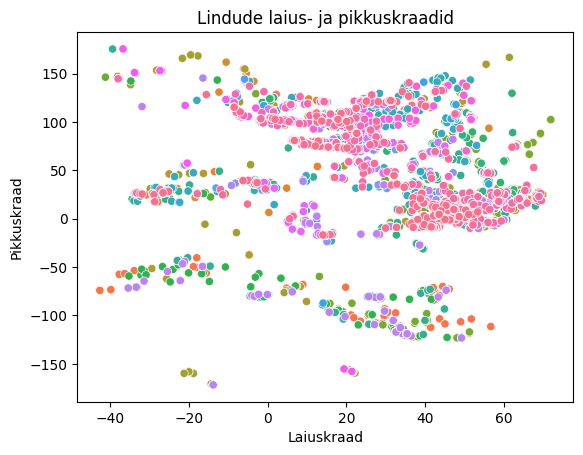

In [8]:
sns.scatterplot(data=metadata, x="latitude", y="longitude", hue="primary_label", legend=False)
plt.title("Lindude laius- ja pikkuskraadid")
plt.xlabel("Laiuskraad")
plt.ylabel("Pikkuskraad")
plt.show()

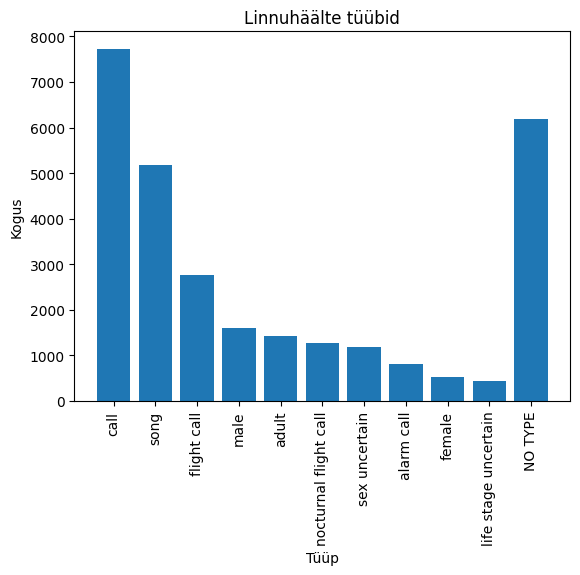

In [9]:
types_value_counts = []
for frequent_type in frequent_types:
  types_value_counts.append(metadata[frequent_type].value_counts()[1])
empty_types = (metadata[frequent_types] == 0).all(axis=1).sum()
frequent_types.append("NO TYPE")
types_value_counts.append(empty_types)
plt.bar(frequent_types, types_value_counts)
plt.title("Linnuhäälte tüübid")
plt.xlabel("Tüüp")
plt.ylabel("Kogus")
plt.xticks(rotation=90)
plt.show()

Esimesel graafikul uuritakse heliklippide kogust enuustatavate liikide kohta. Sellelt on näha, et liigid, mida soovitakse ennustada pole kuidagi moodi tasakaalus. On liike, millel on heliklippe üle 400, kuid osaldel liikidel on kõigest 5 klippi. See võib põhjustada edaspidi probleeme, sest mudel ei pruugi olla võimeline liike ainult viie klipi pealt ennustama. Seetõttu võib olla mõeldav osade liikide mudelist välja jätmine ja ainult nende linnuliikide ennustamine, millel on klippe rohkem.

Teisest graafikust tulevad välja seosed liikide ja pikkus- ning laiuskraadide vahel. On näha, kuidas heliklippe tuleb erinevates paikadest, kust tulevad välja ka peamised seal pesitsevad linnuliigid. Osa linnuliike leidub mitmes eripaigas. See võib mõjutada nende lindude häält, sest nagu inimestel on osadel linnuliikidelgi dialektid.

Kolmandast graamikust on näha, millised on peamised linnuheli tüübid. Tüüpidest on alles jäetud ainult 10 kõige sagedasemat. Kõige sagedasemad on tüübi "call" ja "snog". Samas on siiski ka päris palju heliklippe, millel ei olnud üldse tüüpi või mille tüüp ei kuulu 10 sagedaseima hulka.

### Heliklippide ettevalmistamine

### Mudeli loomine

### Mudeli katsetamine

### Mudeli analüüs ja võimalikud edasiarendused